In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-09-05 18:17:07.706985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 18:17:07.730717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 18:17:07.730883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 9.
_연습문제: 잡음 제거 오토인코더를 사용해 이미지 분류기를 사전훈련해보세요. (간단하게) MNIST를 사용하거나 도전적인 문제를 원한다면 CIFAR10 같은 좀 더 복잡한 이미지 데이터셋을 사용할 수 있습니다. 어떤 데이터셋을 사용하던지 다음 단계를 따르세요._

* 데이터셋을 훈련 세트와 테스트 세트로 나눕니다. 전체 훈련 세트에서 심층 잡음 제거 오토인코더를 훈련합니다.
* 이미지가 잘 재구성되는 지 확인하세요. 코딩 층의 각 뉴런을 가장 크게 활성화하는 이미지를 시각화해보세요.
* 이 오토인코더의 아래 층을 재사용해 분류 DNN을 만드세요. 훈련 세트에서 이미지 500개만 사용해 훈련합니다. 사전훈련을 사용하는 것이 더 나은가요? 사용하지 않는 것이 더 나은가요?

In [2]:
import os
# use cpu only

In [3]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [4]:
print(X_train.shape)
print(type(X_train))

(50000, 32, 32, 3)
<class 'numpy.ndarray'>


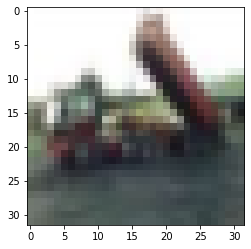

In [5]:
plt.imshow(X_train[2])

In [6]:
coding_size = 512

encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]), # adds gausian noise
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(coding_size, activation="relu"),
])

2022-09-04 01:38:53.128504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-04 01:38:53.129063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 01:38:53.129247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 01:38:53.129368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [7]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 32, 32, 3)        0         
 se)                                                             
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
Non-

In [8]:
decoder = keras.models.Sequential([
    keras.layers.Dense(16*16*32, activation="relu", input_shape=[coding_size]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [9]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 3)        867       
 nspose)                                                         
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [10]:
denoising_ae = keras.models.Sequential([encoder, decoder])

In [11]:
denoising_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512)               4195712   
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         4203363   
                                                                 
Total params: 8,399,075
Trainable params: 8,399,075
Non-trainable params: 0
_________________________________________________________________


In [12]:
denoising_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=["mse"])

In [13]:
#batch_size = 32
#X_train = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size, drop_remainder=True).prefetch(1)
#X_test = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size, drop_remainder=True).prefetch(1)

denoising_ae.fit(X_train, X_train, epochs=20, validation_data=(X_test, X_test))

Epoch 1/20


2022-09-04 01:38:56.194394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-04 01:38:56.652819: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-04 01:38:56.706247: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1563/1563 [==============================] - 8s 3ms/step - loss: 0.5832 - mse: 0.0144 - val_loss: 0.5847 - val_mse: 0.0134
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5663 - mse: 0.0074 - val_loss: 0.5734 - val_mse: 0.0090
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5636 - mse: 0.0064 - val_loss: 0.5702 - val_mse: 0.0080
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5624 - mse: 0.0059 - val_loss: 0.5654 - val_mse: 0.0066
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5617 - mse: 0.0057 - val_loss: 0.5651 - val_mse: 0.0065
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5613 - mse: 0.0055 - val_loss: 0.5648 - val_mse: 0.0064
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5609 - mse: 0.0054 - val_loss: 0.5639 - val_mse: 0.0060
Epoch 8/20
1563/1563 [==============================] - 5s 3ms/step - los

1/1 [==============================] - 0s 74ms/step


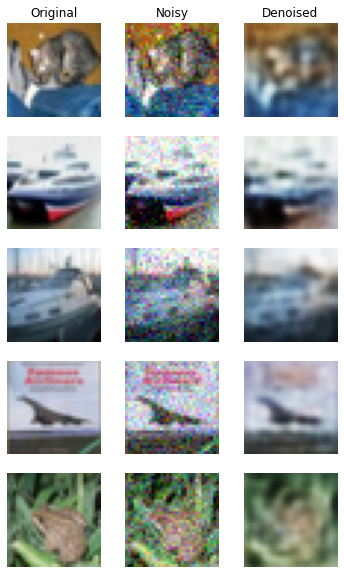

In [14]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

### Use pretrained model

In [15]:
base_model = keras.models.Sequential([encoder, decoder.layers[0]])
for layer in encoder.layers:
    layer.trainable = False

decoder.layers[0].trainables = False

model = keras.models.Sequential([
    base_model,
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="sigmoid", kernel_initializer="he_normal")
])
                        

In [16]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 8192)              8398208   
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                81930     
                                                                 
Total params: 8,480,138
Trainable params: 4,284,426
Non-trainable params: 4,195,712
_________________________________________________________________


In [17]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", 
              metrics=["accuracy"])

In [18]:
idx = np.random.choice(len(X_train), 5000)

In [19]:
X_train_small = X_train[idx]
y_train_small = y_train[idx]

In [ ]:
model.fit(X_train_small, y_train_small, validation_data=(X_test, y_test), epochs=50)

Epoch 1/50
157/157 [==============================] - 1s 6ms/step - loss: 9.0681 - accuracy: 0.1908 - val_loss: 3.7651 - val_accuracy: 0.2804
Epoch 2/50
157/157 [==============================] - 1s 6ms/step - loss: 4.1850 - accuracy: 0.2802 - val_loss: 2.5635 - val_accuracy: 0.3030
Epoch 3/50
157/157 [==============================] - 1s 5ms/step - loss: 2.5876 - accuracy: 0.3158 - val_loss: 1.7671 - val_accuracy: 0.4049
Epoch 4/50
157/157 [==============================] - 1s 5ms/step - loss: 1.9323 - accuracy: 0.3810 - val_loss: 1.7187 - val_accuracy: 0.4061
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 1.7072 - accuracy: 0.4200 - val_loss: 1.7319 - val_accuracy: 0.3957
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 1.6585 - accuracy: 0.4288 - val_loss: 1.6925 - val_accuracy: 0.4071
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 1.5814 - accuracy: 0.4518 - val_loss: 1.7074 - val_accuracy: 0.4031
Epoch 

In [ ]:
model.evaluate(X_test, y_test)